# Recommendation System

## Team
- [Ananda Heino](https://www.linkedin.com/in/ananda-heino-coelho-72154454/)
- [Silvana Santos](https://www.linkedin.com/in/silvana-santos-1a1546209/)

## Dataset
- [MovieLens](https://files.grouplens.org/datasets/movielens/)

## Brief descriptions of the data:

- ml-data.tar.gz   
    - Compressed tar file.  
    - To rebuild the u data files do this:
        - gunzip ml-data.tar.gz
        - tar xvf ml-data.tar
        - mku.sh

- u.data  
    - The full u data set, 100000 ratings by 943 users on 1682 items.
    - Each user has rated at least 20 movies. 
    - Users and items are numbered consecutively from 1.  
    - The data is randomly ordered. 
    - This is a tab separated list of 
        -  user id | item id | rating | timestamp. 
        - The time stamps are unix seconds since 1/1/1970 UTC   

- u.info
    - The number of users, items, and ratings in the u data set.

- u.item    
    - Information about the items (movies); 
    - this is a tab separated list of
         - movie id | movie title | release date | video release date |
         - IMDb URL | unknown | Action | Adventure | Animation |
         - Children's | Comedy | Crime | Documentary | Drama | Fantasy |
         - Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
         - Thriller | War | Western |
         
         - The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once.
         - The movie ids are the ones used in the u.data data set.

- u.genre   
    - A list of the genres.

- u.user     
    - Demographic information about the users;
    - this is a tab separated list of 
        - user id | age | gender | occupation | zip code
     - The user ids are the ones used in the u.data data set.

- u.occupation 
    - A list of the occupations.

In [1]:
!conda install -c -y conda-forge lightfm
#!conda install pickle
#!pip install statsmodels

usage: conda install [-h] [--revision REVISION] [-n ENVIRONMENT | -p PATH]
                     [-c CHANNEL] [--use-local] [--override-channels]
                     [--repodata-fn REPODATA_FNS] [--strict-channel-priority]
                     [--no-channel-priority] [--no-deps | --only-deps]
                     [--no-pin] [--copy] [-C] [-k] [--offline] [-d] [--json]
                     [-q] [-v] [-y] [--download-only] [--show-channel-urls]
                     [--file FILE] [--force-reinstall]
                     [--freeze-installed | --update-deps | -S | --update-all | --update-specs]
                     [-m] [--clobber] [--dev]
                     [package_spec [package_spec ...]]
conda install: error: argument -c/--channel: expected one argument


In [2]:
import pickle
import pandas as pd
from lightfm.data import Dataset
from lightfm import LightFM
import numpy as np
import re
import time
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from dateutil.parser import parse
import plotly.express as px

# Reading the data:
- `u.data`
- `u.user`

In [21]:
df_data = pd.read_csv('data/u.data', sep ='\t', header = None)

In [22]:
df_data.rename(columns = {0:'user_id', 1:'item_id', 2:'rating', 3:'timestamp'}, inplace = True)
df_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
df_user = pd.read_csv('data/u.user', sep ='|', header = None)

In [24]:
df_user.rename(columns = {0:'user_id', 1:'age', 2:'gender', 3:'occupation', 4: 'zipcode'}, inplace = True)
df_user.head()

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [26]:
df_data = pd.merge(df_data, df_user, how = 'inner', on = 'user_id')
df_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zipcode
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


In [27]:
df_data.describe().round(2)

,user_id,item_id,rating,timestamp,age
count,100000.00,100000.00,100000.00,1.000000e+05,100000.00
mean,462.48,425.53,3.53,8.835289e+08,32.97
std,266.61,330.80,1.13,5.343856e+06,11.56
min,1.00,1.00,1.00,8.747247e+08,7.00
25%,254.00,175.00,3.00,8.794487e+08,24.00
50%,447.00,322.00,4.00,8.828269e+08,30.00
75%,682.00,631.00,4.00,8.882600e+08,40.00
max,943.00,1682.00,5.00,8.932866e+08,73.00


In [56]:
df = pd.DataFrame(df_data['occupation'].value_counts())
df = df.reset_index()
fig = px.bar(df, x='index', y='occupation', title='Occupation Count', labels={'occupation':'Count', 'index':'Occupation'})
fig.show()

,index,occupation
0,student,21957
1,other,10663
2,educator,9442
3,engineer,8175
4,programmer,7801
5,administrator,7479
6,writer,5536
7,librarian,5273
8,technician,3506
9,executive,3403


### We can see that most of the users are students.

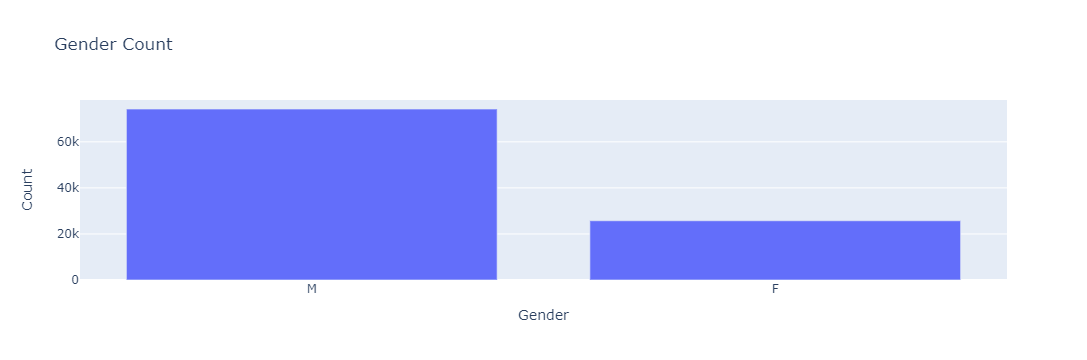

In [55]:
df = pd.DataFrame(df_data['gender'].value_counts())
df = df.reset_index()
fig = px.bar(df, x='index', y='gender', title='Gender Count', labels={'gender':'Count', 'index':'Gender'})
fig.show()

### We can see that most of the users are male.
 - thus, the dataset is unbalanced 


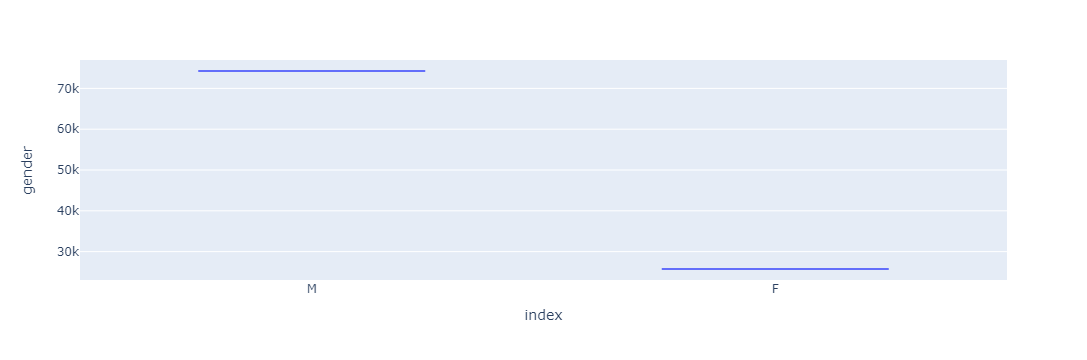

In [50]:
fig = px.box(df_gender, x='index', y='gender')
fig.show()

***
## Plotting Gender and Occupation for each rating value

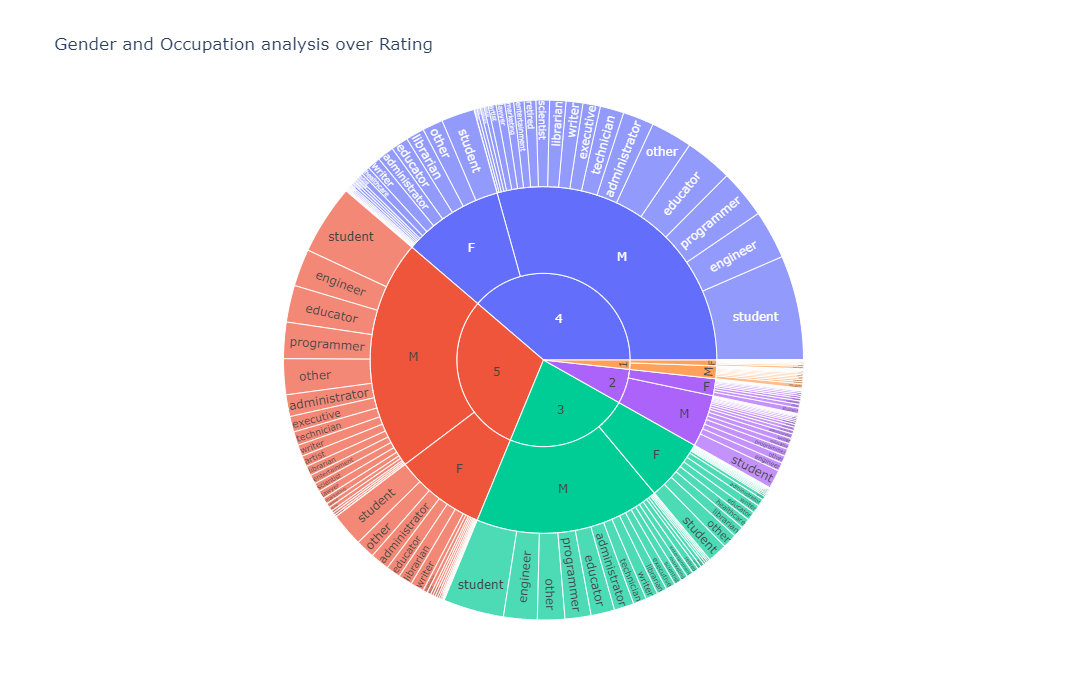

In [28]:
fig = px.sunburst(df_data, path=['rating', 'gender', 'occupation'], values='rating', title='Gender and Occupation analysis over Rating', height=700)
display(fig)